# Sentiment Time Series Generation

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import ast
from transformers import pipeline
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-01-31 23:00:37.410122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 23:00:37.410145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [3]:
df.head()

,index,lyrics,genre,outlier,id,similar_lyrics,random_lyrics
0,17253,"[""All i know when #i'm# with you"", 'My little...",rap,False,17253,"[""All y knew was #i'm# with that"", 'My little...","['The more you see of your love', 'The more yo..."
1,24217,"[""Kells, you know i can't keep doing this, i g...",rap,False,24217,"[""Kells, your know im can't resist doing it, i...","['Oh God! Oh God! Ugh', ""9-1-1 What's your eme..."
2,18238,"['Put on your booty shorts', 'Ooh, I really li...",rap,False,18238,"['Put on those booty kit', 'Ooh, I really like...","['Verse One: Raekwon the Chef', 'Machine gun r..."
3,17181,"['Fargo, get on some real yard shit', 'Come in...",rap,False,17181,"['Fargo, spilling over the real yard shit', 'C...","[""See you've got the new biography"", 'Where di..."
4,14845,"['Hands up in the air', 'I just want the', 'I ...",rap,False,14845,"['Hands flung into the air', 'I just wanted to...","['More rest and sex is all a nigga needs', 'In..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           100 non-null    int64 
 1   lyrics          100 non-null    object
 2   genre           100 non-null    object
 3   outlier         100 non-null    bool  
 4   id              100 non-null    int64 
 5   similar_lyrics  100 non-null    object
 6   random_lyrics   100 non-null    object
dtypes: bool(1), int64(2), object(4)
memory usage: 4.9+ KB


In [5]:
df['lyrics'] = list(map(lambda x: ast.literal_eval(x), df['lyrics']))
df['similar_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['similar_lyrics']))
df['random_lyrics'] = list(map(lambda x: ast.literal_eval(x), df['random_lyrics']))

In [6]:
random.choice(df['lyrics'])

['The Beautiful Occupation Lyricsby Travis',
 'Don´t just stand there watching it happening',
 'I can´t stand it',
 'Don´t feel it',
 'Something´s telling me',
 'Don´t wanna go out this way',
 'But have a nice day',
 'Then read it in the headlines',
 'Watch it on the TV',
 'Put it in the background',
 'Stick it in the bag',
 'Stick it in the bag',
 'For the beautiful occupation',
 'The beautiful occupation',
 'You don´t need an invitation',
 'To drop in upon a nation',
 'I´m too cynical',
 'I´m just sitting here',
 'I´m just wasting my time',
 'Half a million civillians gonna die today',
 'But look the wrong way',
 'Then read it in the headlines',
 'Watch it on the TV',
 'Put it in the background',
 'Stick it in the bag',
 'Stick it in the bag',
 'For the beautiful occupation',
 'The beautiful occupation',
 'You don´t need an invitation',
 'To drop in upon a nation',
 'Don´t just stand there watching it happening',
 'I can´t stand it',
 'Don´t feel it',
 'Something telling me',
 'Don´t

In [7]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"I wake up every morning, with the sun in my eyes",verse
1,"I stumble out of bed, and I hit the ground run...",verse
2,"I've got a lot on my plate, but I don't mind t...",verse
3,"I know I've got what it takes, to make it down...",verse
4,"I'm living for today, and I'm chasing my dreams",chorus


In [8]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['I wake up every morning, with the sun in my eyes',
 'I stumble out of bed, and I hit the ground running',
 "I've got a lot on my plate, but I don't mind the load",
 "I know I've got what it takes, to make it down the road",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I hit the pavement, and I don't look back",
 "I've got my foot on the gas, and I'm on the right track",
 "I know I've got what it takes, to make it to the top",
 "I won't stop until I reach the mountaintop",
 "I'm living for today, and I'm chasing my dreams",
 "I won't let anyone stand in my way, or burst at the seams",
 "I'm on a mission, to reach for the stars",
 "I'm unstoppable, behind the steering wheel of my car",
 "I've got my eyes on the prize, and I won't let it go",
 "I'll keep on fighting, with all my might and my mojo"]

## Sentiment

In [9]:
sent_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english")

In [10]:
sentences = ['I love you', 'I hate you', 'I am going to the store to buy some milk.']

model_output = sent_pipeline(sentences)
model_output

[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079},
 {'label': 'NEGATIVE', 'score': 0.9932184815406799}]

In [11]:
def get_unique_sentiment(sentiment_output):
    # Map sentiment in a unique value ranging [-1,1]
    unique_sentiments = []
    for so in sentiment_output:
        if so['label'] == 'POSITIVE':
            pos = so['score']
            neg = 1 - pos
        else:
            neg = so['score']
            pos = 1- neg
        unique_sentiments.append(pos - neg)
    return unique_sentiments

In [12]:
unique_scores = get_unique_sentiment(model_output)
list(zip(sentences, unique_scores))

[('I love you', 0.9997313022613525),
 ('I hate you', -0.9982258081436157),
 ('I am going to the store to buy some milk.', -0.9864369630813599)]

In [13]:
eg_sentibert_ts = get_unique_sentiment(sent_pipeline(eg_lyrics))

In [14]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

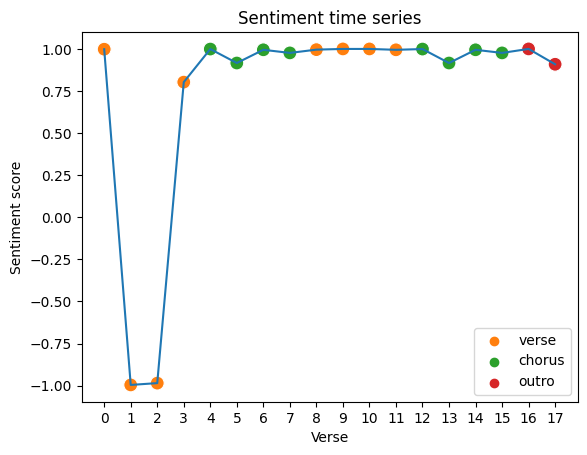

In [15]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_sentibert_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentibert_ts, 
                     x = range(len(eg_sentibert_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentibert_ts)))
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment time series')
plt.show()

In [ ]:
sentibert_ts = [get_unique_sentiment(sent_pipeline(lyrics)) for lyrics in tqdm(df['lyrics'])]

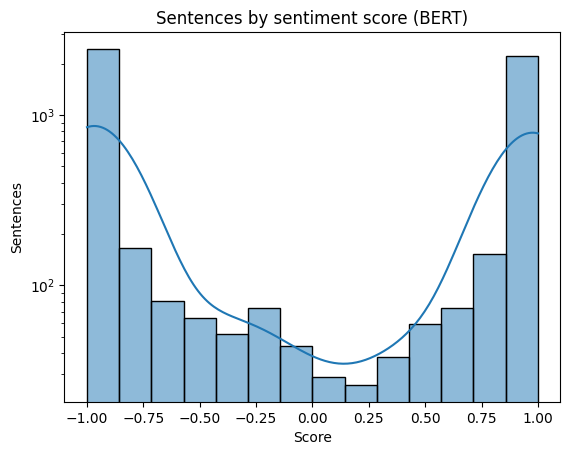

In [17]:
bert_scores = [score for sb_ts in sentibert_ts for score in sb_ts]

fig, ax = plt.subplots()
ax = sns.histplot(bert_scores, kde=True)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_yscale('log')
ax.set_title('Sentences by sentiment score (BERT)')

plt.show()

In [18]:
# VADER model
sid = SentimentIntensityAnalyzer()

for sentence in sentences:
    print(sentence, sid.polarity_scores(sentence)['compound'])

I love you 0.6369
I hate you -0.5719
I am going to the store to buy some milk. 0.0


In [19]:
generate_vader_ts = lambda lyrics: [sid.polarity_scores(verse)['compound'] for verse in lyrics]

eg_sentivader_ts = generate_vader_ts(eg_lyrics)

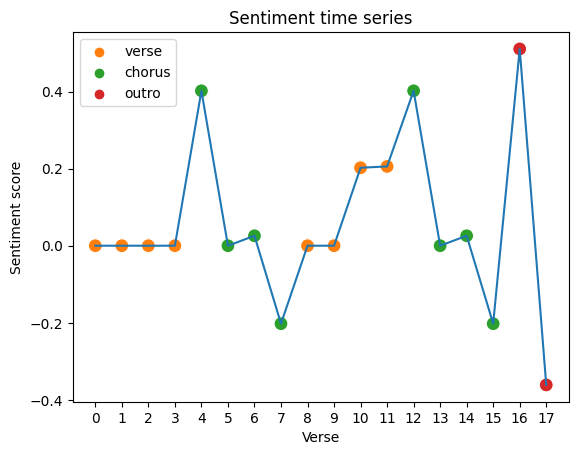

In [20]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_sentivader_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentivader_ts, 
                     x = range(len(eg_sentivader_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentivader_ts)))
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment time series')
plt.show()

In [ ]:
vader_sen_ts = []

for lyrics in tqdm(df['lyrics']):
    vader_sen_ts.append([sid.polarity_scores(verse)['compound'] for verse in lyrics])

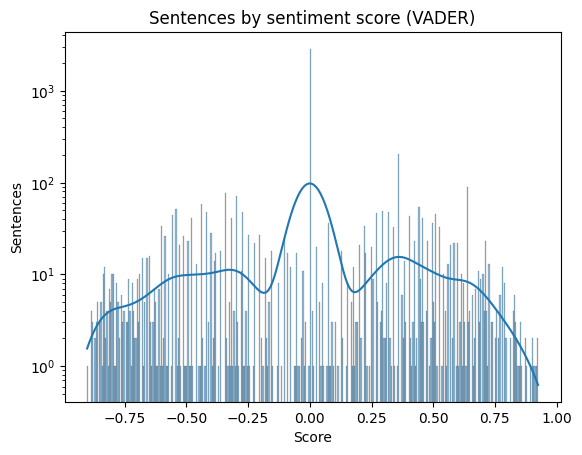

In [22]:
vader_scores = [score for vst in vader_sen_ts for score in vst]

fig, ax = plt.subplots()
ax = sns.histplot(vader_scores, kde=True)
ax.set_xlabel('Score')
ax.set_ylabel('Sentences')
ax.set_title('Sentences by sentiment score (VADER)')
ax.set_yscale('log')
plt.show()

In [23]:
corr = np.corrcoef(vader_scores, bert_scores)[0, 1]

print(f'Correlation VADER and BERT sentiment scores: {corr}')

Correlation VADER and BERT sentiment scores: 0.39193849577801254


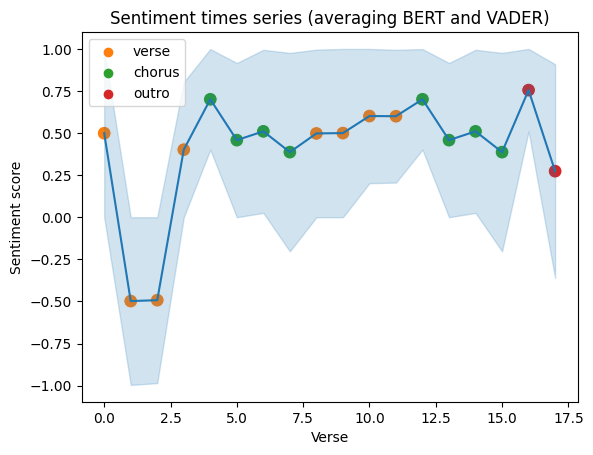

In [24]:
fig, ax = plt.subplots()
# Compute mean for basic scatteplot
eg_sent_ts = np.mean(np.column_stack((eg_sentibert_ts, eg_sentivader_ts)), axis=1)
ax = sns.scatterplot(y = eg_sent_ts, 
                     x = range(len(eg_sent_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
# Create a DataFrame for lineplot
data = {'sentiment': eg_sentibert_ts + eg_sentivader_ts,
        'model': ['bert'] * len(eg_sentibert_ts) + ['vader'] * len(eg_sentivader_ts),
        'timestamp': list(range(0,len(eg_sentibert_ts))) + list(range(0,len(eg_sentivader_ts)))}
eg_sent_ts = pd.DataFrame(data)
ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment')
ax.set_xlabel('Verse')
ax.set_ylabel('Sentiment score')
ax.set_title('Sentiment times series (averaging BERT and VADER)')
plt.show()

In [ ]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    print(lyrics_type)
    ts_data[lyrics_type] = []
    for lyr in tqdm(df[lyrics_type]):
        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr))
        sentivader_ts = generate_vader_ts(lyr)
        sentiment_ts = np.mean(np.column_stack((sentibert_ts, sentivader_ts)), axis=1)
        sentiment_ts = list(sentiment_ts)
        ts_data[lyrics_type].append(sentiment_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/sentiment_ts.csv'
ts_data.to_csv(filename, index=False)
print('___')

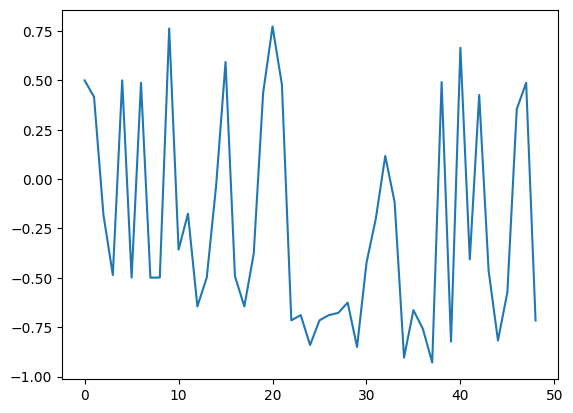

In [26]:
plt.plot(random.choice(ts_data['lyrics']))

## Emotion

In [27]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [28]:
def get_logits(sentence, tokenizer, model, to_numpy=False):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    if to_numpy:
        return logits[0].numpy()
    else:
        return logits

In [29]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [30]:
sentences = ["I am so happy right now!",            
            "What a beautiful surprise!.",
            "This news made me feel so worried.",
            "I am so excited for my vacation!",
            "I am feeling really calm and content.",
            "That smell is making me feel so disgusted.",
            "I am going to the store to buy some milk"]

In [31]:
logits_tensor = [get_logits(sentence, tokenizer=tokenizer, model=model) for sentence in sentences]
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [32]:
labels

['joy', 'joy', 'fear', 'joy', 'joy', 'disgust', 'neutral']

In [33]:
eg_multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, model=model, to_numpy=True) for verse in eg_lyrics])

In [34]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in eg_lyrics]
labels = [logits2label(lt, model=model) for lt in logits_tensor]

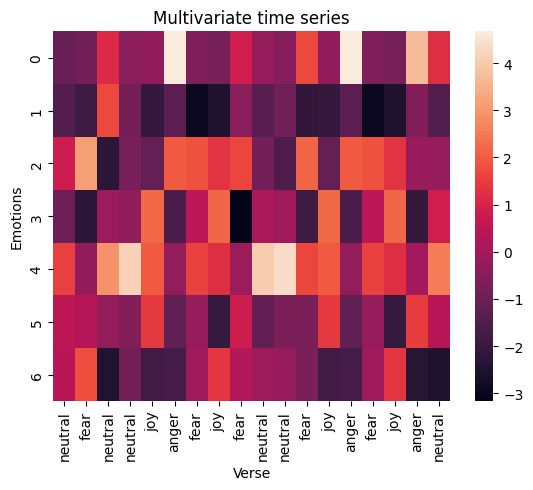

In [35]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('Verse')
ax.set_ylabel('Emotions')
ax.set_title('Multivariate time series')
ax.set_xticklabels(labels, rotation=90)
plt.show()

In [36]:
global_scaler = joblib.load('../models/emo_scaler.pkl')
global_pca = joblib.load('../models/emo_pca.pkl')

In [37]:
pca_output = global_pca.transform(global_scaler.transform(eg_multi_ts))

eg_unigpca_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

In [38]:
color_map = {}
for idx, label in enumerate(list(dict.fromkeys(labels))):    
    # Map color excluding first color of the palette 
    color_map[label] = sns.color_palette()[idx+1]

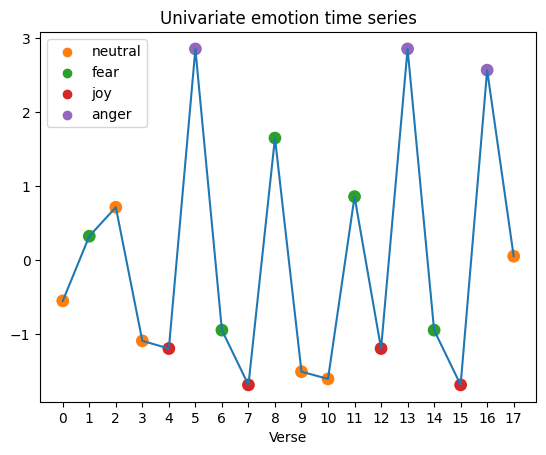

In [39]:
fig, ax = plt.subplots()
ax = sns.lineplot(eg_unigpca_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_unigpca_ts, 
                     x = range(len(eg_unigpca_ts)),
                     hue=labels, s=100,
                     palette=color_map)
ax.set_xlabel('Verse')
ax.set_title('Univariate emotion time series')
ax.set_xticks(range(len(eg_unigpca_ts)))
plt.show()

In [ ]:
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    print(lyrics_type)
    ts_data[lyrics_type] = []
    for lyr in tqdm(df[lyrics_type]):
        multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, 
                             model=model, to_numpy=True) for verse in lyr])
        scl_multi_ts = global_scaler.transform(multi_ts)
        pca_output = global_pca.transform(scl_multi_ts)
        emotion_ts = list(
            map(lambda unique_element: unique_element[0], pca_output))        
        ts_data[lyrics_type].append(emotion_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/emotion_ts.csv'
ts_data.to_csv(filename, index=False)
print('___')

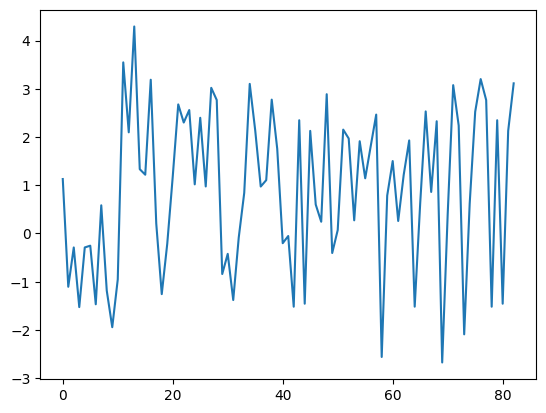

In [41]:
plt.plot(random.choice(ts_data['lyrics']))